In [1]:

import pandas
import numpy

import seaborn
from matplotlib import pyplot as plt

In [55]:


def load_data(path):
    columns = [
        'event',
        'time',
        'value',
    ]
    df = pandas.read_csv(path, names=columns)
    df = df[df.event.isin(['val'])]
    df = df.drop(columns=['event'])
    df['time'] = pandas.to_timedelta(df['time'], unit='ms')
    df = df.set_index('time')
    return df

#data = load_data('../data/first-100hz-pulse-sitting-thumb-1.csv')
data = load_data('../green4-25hz-pointy-1.csv')
data

,value
time,
0 days 00:02:03.600000,44
0 days 00:02:03.640000,55
0 days 00:02:03.680000,57
0 days 00:02:03.720000,57
0 days 00:02:03.760000,56
...,...
0 days 00:02:31.720000,51
0 days 00:02:31.760000,50
0 days 00:02:31.800000,51


<Axes: xlabel='time', ylabel='value'>

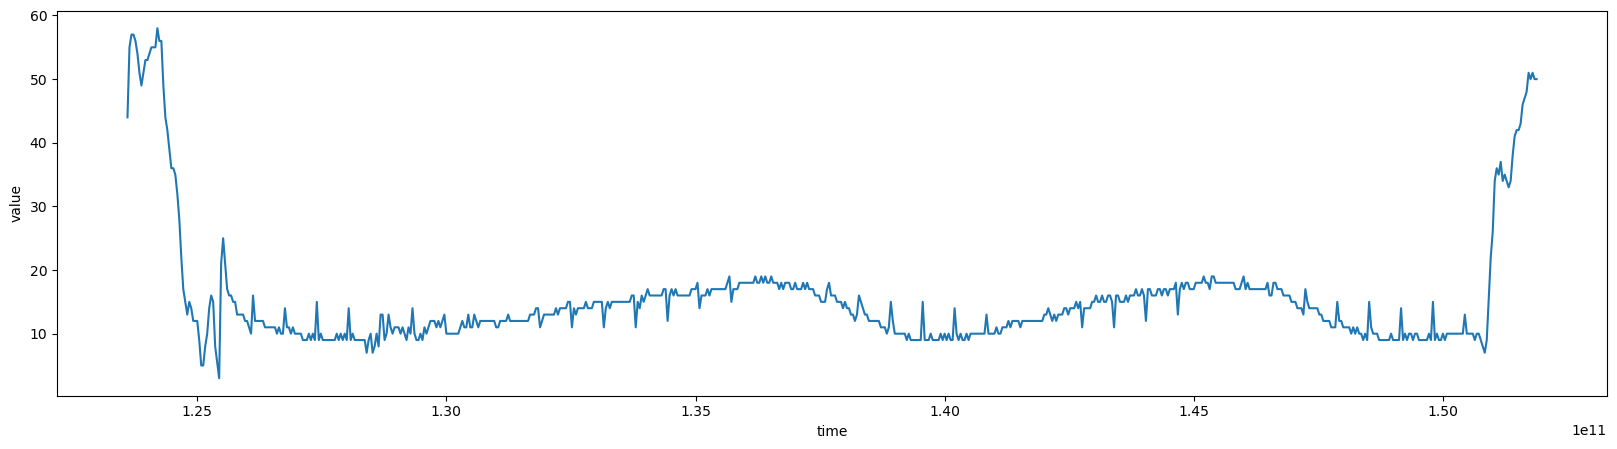

In [56]:
fig, ax = plt.subplots(1, figsize=(20, 5))
seaborn.lineplot(ax=ax, data=data.reset_index(), x='time', y='value')

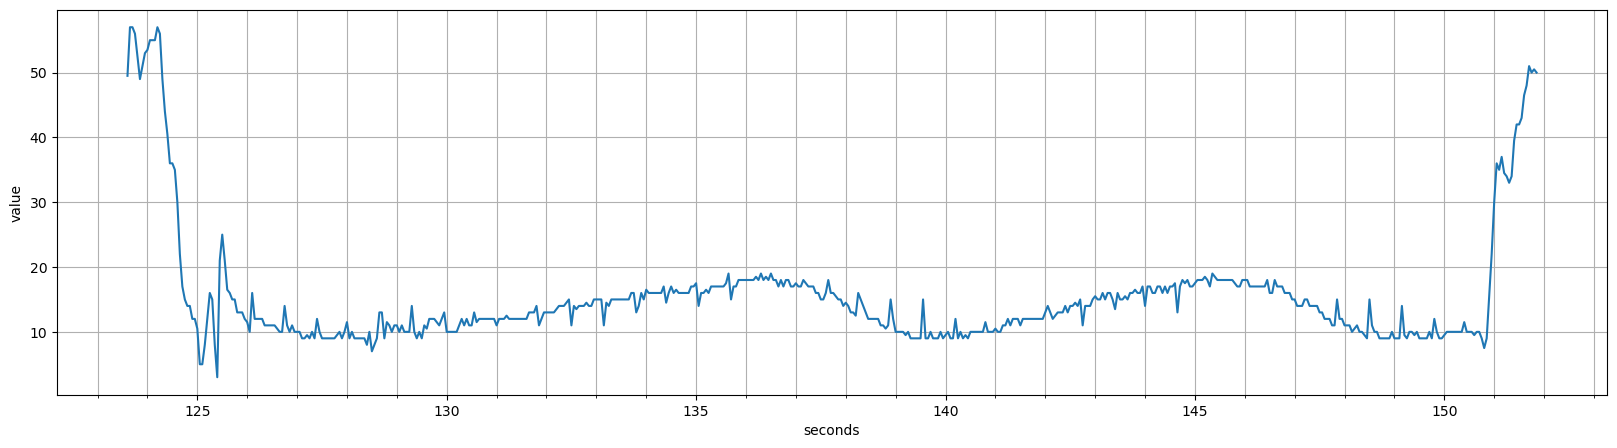

In [63]:

    rr = data.resample('50ms').median()
fig, ax = plt.subplots(1, figsize=(20, 5))
rr = rr.reset_index()
rr['seconds'] = rr['time'].dt.total_seconds()
seaborn.lineplot(ax=ax, data=rr.reset_index(), x='seconds', y='value')
#seaborn.scatterplot(ax=ax, data=rr.reset_index(), x='seconds', y='value')

from matplotlib import ticker
#ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.grid(which='minor')
ax.grid(which='major')


,time,value,seconds
0,0 days 00:02:03.600000,NaN,123.60
1,0 days 00:02:03.640000,NaN,123.64
2,0 days 00:02:03.680000,NaN,123.68
3,0 days 00:02:03.720000,NaN,123.72
4,0 days 00:02:03.760000,NaN,123.76
...,...,...,...
701,0 days 00:02:31.720000,35.0,151.72
702,0 days 00:02:31.760000,35.0,151.76
703,0 days 00:02:31.800000,36.0,151.80
704,0 days 00:02:31.840000,37.0,151.84


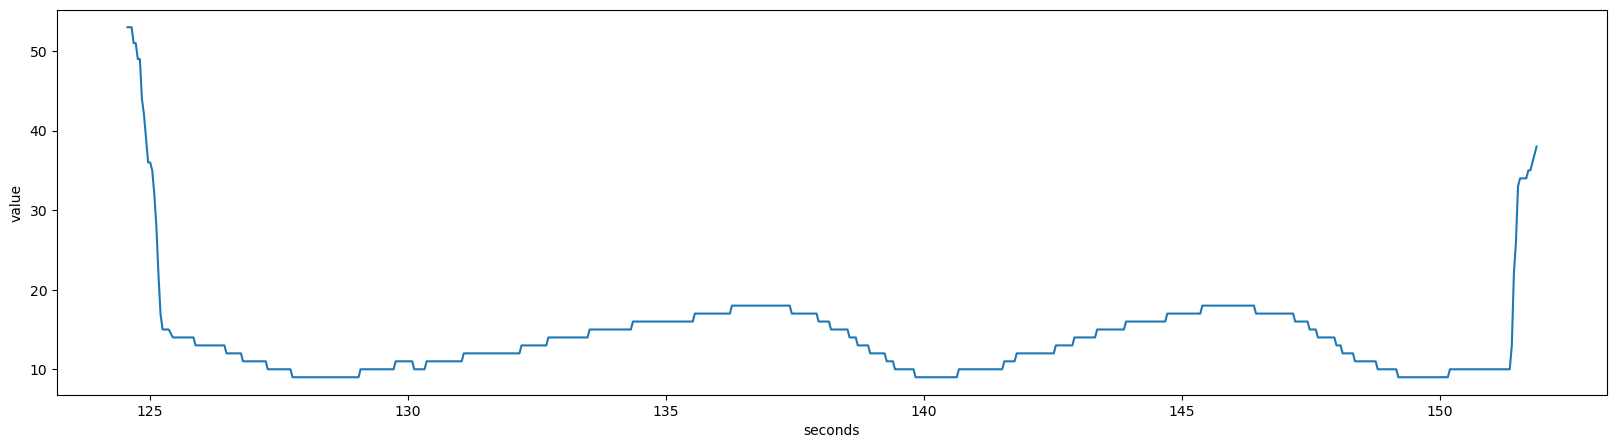

In [87]:
ss = data.rolling(window=25).median()
fig, ax = plt.subplots(1, figsize=(20, 5))
ss = ss.reset_index()
ss['seconds'] = ss['time'].dt.total_seconds()
seaborn.lineplot(ax=ax, data=ss.reset_index(), x='seconds', y='value')
ss

,value
time,
0 days 00:02:03.600000,NaN
0 days 00:02:03.640000,NaN
0 days 00:02:03.680000,NaN
0 days 00:02:03.720000,NaN
0 days 00:02:03.760000,NaN
...,...
0 days 00:02:31.720000,35.0
0 days 00:02:31.760000,35.0
0 days 00:02:31.800000,36.0


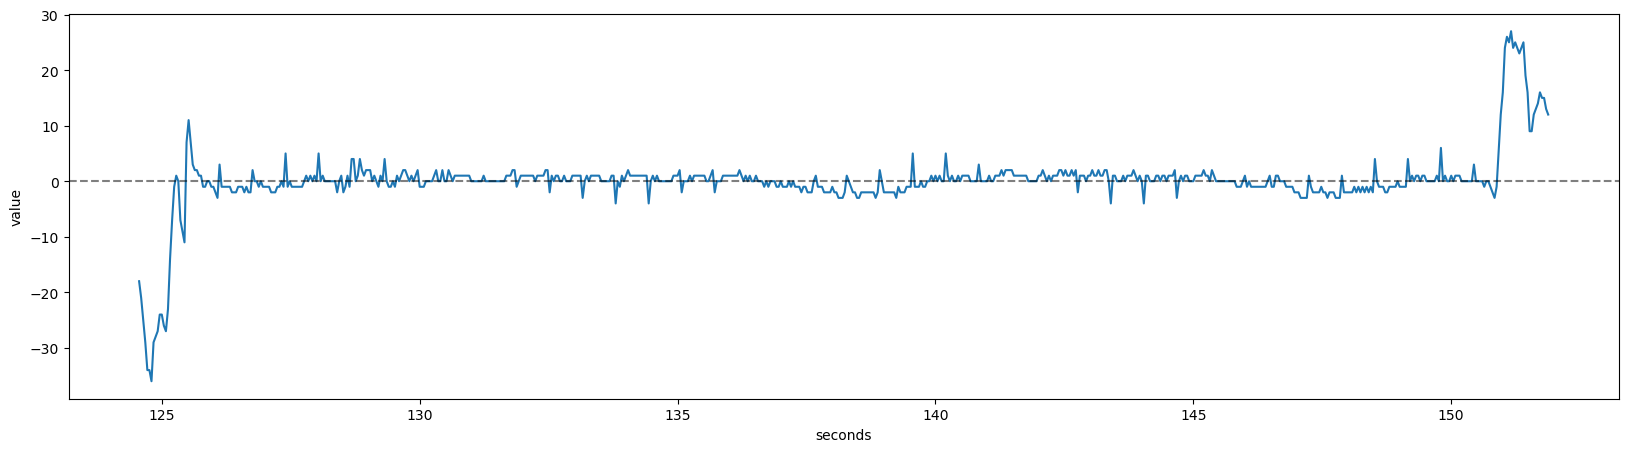

In [91]:
ss = data.rolling(window=25).median()
fig, ax = plt.subplots(1, figsize=(20, 5))
rr = data.copy()
rr['value'] = rr['value'] - ss['value']
rr['seconds'] = rr.index.total_seconds()
seaborn.lineplot(ax=ax, data=rr.reset_index(), x='seconds', y='value')
ax.axhline(0.0, ls='--', color='black', alpha=0.5)
ss

In [94]:
sub =  rr[(rr.seconds > 128) & (rr.seconds < 150)]
sub

,value,seconds
time,,
0 days 00:02:08.040000,5.0,128.04
0 days 00:02:08.080000,0.0,128.08
0 days 00:02:08.120000,1.0,128.12
0 days 00:02:08.160000,0.0,128.16
0 days 00:02:08.200000,0.0,128.20
...,...,...
0 days 00:02:29.800000,6.0,149.80
0 days 00:02:29.840000,0.0,149.84
0 days 00:02:29.880000,1.0,149.88


<Axes: xlabel='bpm', ylabel='value'>

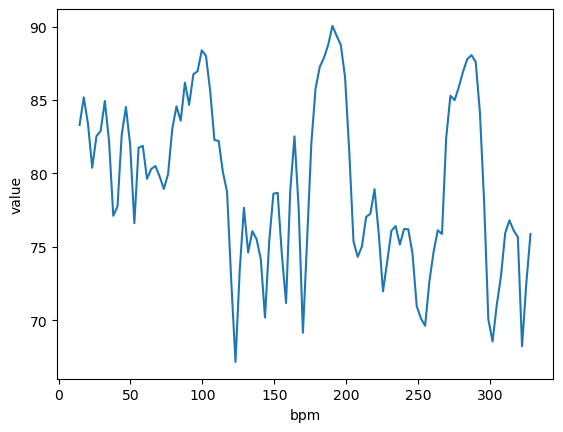

In [119]:
import scipy.signal

def spectrum_stft(audio, sr, n_fft, window):
    """Method 1: Compute magnitude spectrogram, average over time"""
    S = librosa.stft(audio, n_fft=n_fft, window=window)
    S_db = librosa.amplitude_to_db(numpy.abs(S*S), ref=0.0, top_db=120)
    freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
    spectrum = numpy.mean(S_db, axis=1)
    return pandas.Series(spectrum, index=freqs)

def spectrum_welch(audio, sr, n_fft, window):
    """Method 2: Use Welch method. Uses overlapped complex spectrum"""
    freqs, power = scipy.signal.welch(audio, fs=sr, nfft=n_fft, window=window,
        scaling="spectrum", average='median')
    db = librosa.power_to_db(power, ref=0.0, top_db=120)
    return pandas.Series(db, index=freqs)

spectrum = spectrum_welch(sub.value, sr=25, n_fft=512, window='hann')
spectrum = spectrum.to_frame()
spectrum.index.name='frequency'
spectrum = spectrum.rename(columns={0: 'value'})
spectrum = spectrum.loc[0.20:5.5]
spectrum['bpm'] = spectrum.index * 60
seaborn.lineplot(data=spectrum.reset_index(), x='bpm', y='value')

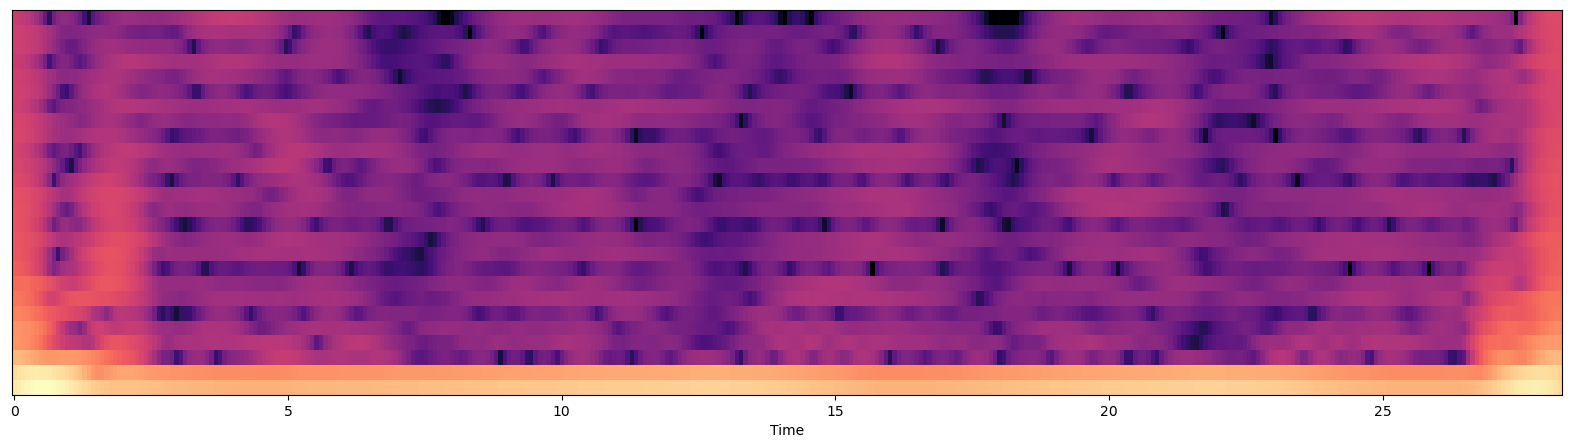

In [82]:
import librosa

hop = 2
n_fft = 50

fig, ax = plt.subplots(1, figsize=(20, 5))
S = numpy.abs(librosa.stft(y=data.value.astype(float).values, hop_length=hop, n_fft=n_fft))
S_db = librosa.amplitude_to_db(S, ref=0.0)

librosa.display.specshow(S_db, ax=ax, sr=25, x_axis='time', hop_length=hop)
